In [1]:
# built-in
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import time as Time

# third-party (install required)
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats import pearsonr
from yellowbrick.model_selection import RFECV
from statistics import mean
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, f1_score, fbeta_score, make_scorer, plot_confusion_matrix, confusion_matrix

from sklearn.utils import compute_class_weight

import dnacurve

from numpy import inf

import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

from collections import Counter
from Bio.SeqUtils import GC

# local modules
sys.path.append('../../../bitome2')

from bitome.core import Bitome

# define paths
K12_DATA_PATH = Path('../../data/bitome2/mg1655')


In [4]:
synthesized_promoter = pd.read_excel('Nonrepetitive_parts.xls', sheet_name=1)
XY_dict_all = pd.read_csv('XY_dict_all', index_col=0)

In [5]:
XY_dict_all

,box_10_70,box_10_54,box_10_38,box_10_32,box_10_28,box_10_24,box_35_70,box_35_54,box_35_38,box_35_32,...,AT_upstream_24,spacer_70,spacer_54,spacer_38,spacer_32,spacer_28,spacer_24,label,sigma,synthesize
0,7.269365,-2.186053,4.933934,0.797476,-100000.000000,2.450608,4.269196,-11.096977,3.468664,2.719097,...,0.380952,19.0,15.0,20.0,17.0,13.0,7.0,1,Sigma70,False
1,4.733170,7.225105,6.969339,1.596564,-6.087339,-0.401141,3.301839,10.184823,4.121858,0.853326,...,0.476190,29.0,10.0,20.0,22.0,19.0,6.0,0,NaN,False
2,2.028400,4.180711,0.834322,0.230436,-0.194537,3.245290,2.754900,0.424623,3.468664,3.351073,...,0.666667,21.0,16.0,10.0,22.0,15.0,25.0,0,NaN,False
3,4.733170,7.225105,6.969339,1.596564,-6.087339,-0.401141,3.301839,10.184823,4.121858,0.853326,...,0.428571,29.0,10.0,20.0,22.0,19.0,10.0,1,Sigma54,False
4,5.633262,-2.186053,-1.014663,-0.202524,-0.413372,3.728142,2.873597,-100000.000000,3.343133,1.728142,...,0.571429,10.0,5.0,13.0,10.0,16.0,21.0,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,11.000000,21.000000,25.000000,13.000000,11.000000,28.000000,16.000000,17.000000,13.000000,20.000000,...,18.000000,24.0,23.0,20.0,21.0,15.0,22.0,1,Sigma70,True
4347,19.000000,11.000000,30.000000,31.000000,10.000000,27.000000,19.000000,15.000000,19.000000,12.000000,...,16.000000,24.0,10.0,12.0,20.0,19.0,18.0,1,Sigma70,True
4348,21.000000,8.000000,11.000000,6.000000,25.000000,16.000000,16.000000,11.000000,15.000000,18.000000,...,21.000000,19.0,17.0,23.0,14.0,8.0,8.0,1,Sigma70,True
4349,17.000000,12.000000,10.000000,17.000000,17.000000,10.000000,16.000000,16.000000,16.000000,10.000000,...,6.000000,15.0,11.0,12.0,19.0,23.0,16.0,1,Sigma70,True


In [6]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [7]:
all_sigma_motif_dict = mg1655.create_sigma_motifs()

# Featurized the synthesized promoters

In [92]:
# need to be modified

def scores_by_sequence(sequence, search_range=(15,5), upstream_range=(-65, -45)):
    score_dict = {}
    all_sigma_motif_dict = mg1655.create_sigma_motifs()
    
    for sigma_name, sigma_motif_dict in all_sigma_motif_dict.items():
        
        box_10_lens = len(sigma_motif_dict['-10'].consensus)
        box_10_tss_dists = sigma_motif_dict['b10_tss_lens']

        spacer_lens = sigma_motif_dict['spacer_lens']
        box_35_tss_dists = np.mean(box_10_tss_dists) + np.mean(spacer_lens)
        
        box_35_lens = len(sigma_motif_dict['-35'].consensus)
        box_10_tss_dists = np.mean(box_10_tss_dists)
        
        # since the promoters are synthezied, assume all forward strand 
            
        #print(-int(search_range[0]+box_10_tss_dists) , int(- box_10_tss_dists+search_range[1]))
        
        search_sequence_10 = sequence[-int(20 + search_range[0]+box_10_tss_dists) : int(- 20 - box_10_tss_dists+search_range[1])]
        
        #print(search_sequence_10)
        score_10 = np.max(sigma_motif_dict['-10'].pssm.calculate(search_sequence_10))
        ind_score_10 = np.argmax(sigma_motif_dict['-10'].pssm.calculate(search_sequence_10))
            
        #print(int(- 20 - box_35_tss_dists - search_range[0]) , int(-20 - box_35_tss_dists+search_range[1]))
        search_sequence_35 = sequence[int(- 20 - box_35_tss_dists - search_range[0]) : int(-20 - box_35_tss_dists+search_range[1])]
        score_35 = np.max(sigma_motif_dict['-35'].pssm.calculate(search_sequence_35))
        ind_score_35 = np.argmax(sigma_motif_dict['-35'].pssm.calculate(search_sequence_35))
            
        upstream = sequence[int(-20 + upstream_range[0]) : int(-20 + upstream_range[1])]
        
        # doesn't have UTR region
        # UTR = sequence[0 : int(UTR_range)]
            
            
        pos_10 = round(-(20 + search_range[0]+box_10_tss_dists) + ind_score_10 + box_10_lens)
        pos_35 = round((- 20 - box_35_tss_dists - search_range[0]) + ind_score_35 + box_35_lens)
            
            
        AT_upstream = (100 - GC(upstream))/100
        # AT_UTR = (100 - GC(UTR))/100
        
        spacer_length = abs(pos_35 - pos_10)
        
        score_dict[sigma_name] = {'score_10_max': score_10,
                                  'score_35_max': score_35,
                                  'AT_upstream': np.max(AT_upstream),
                                  #'AT_UTR': np.max(AT_UTR),
                                  'spacer_length': np.max(spacer_length)
                                 }
    
    return score_dict

In [86]:
synthesized_promoter['sigma'] = 'Sigma70'
synthesized_promoter['label'] = '1'
synthesized_promoter['synthesize'] = True

In [87]:
synthesized_promoter

,PROMOTER ID,PROMOTER SEQUENCE,BARCODE,TOOLBOX,MISMATCHES,R1-DNA-COUNT,R2-DNA-COUNT,R1-RNA-COUNT,R2-RNA-COUNT,R1-DNA-COUNT-NORMALIZED,NORMALIZED-R2-DNA-COUNT,NORMALIZED-R1-RNA-COUNT,NORMALIZED-R2-RNA-COUNT,NORMALIZED-TX-RATE-MEAN,NORMALIZED-TX-RATE-STDEV,sigma,label,synthesize
0,SLP2018-1-1,GGGCCCCTACTCACCGAGGATTGACATATTGCCTACCAGCGTGTAT...,CTCTGGCTCGTGATGCCAAG,1,0.0,3798,3776,15472,11061,3410.093948,4231.792073,11347.113853,14533.042901,11.728189,2.046538,Sigma70,1,True
1,SLP2018-1-2,ACGTGCGCTAGGCCAGCCGATTGACATCTGGTTTTCTGCATAGTAT...,TAGTTGTGACAACAAGGCGA,1,0.0,8842,10345,10894,12895,9222.929422,9767.529980,13382.635261,10469.908184,4.260632,0.038779,Sigma70,1,True
2,SLP2018-1-3,GTCATCCGGCTCGTGTTGGGTTGACAGCGCGCCTCAGATTGGATAT...,TAAGACGACGCGGTTAGCCC,1,0.0,4047,4740,6718,6442,4274.586783,4505.095227,6420.456503,6588.668341,5.118120,0.747912,Sigma70,1,True
3,SLP2018-1-4,GCAGGCTAGTCTGGTCTCGTTTGACATTAAGAGGTATGGAGGATAT...,ATATGTTGTCCATGCGCGGC,1,0.0,3410,2995,36668,25200,2709.072899,3805.813402,27798.485415,32164.434533,31.877170,2.021227,Sigma70,1,True
4,SLP2018-1-5,ACAAGTTGCGGTCCGGGCATTTGACAACTTGTACGCCGACCCGTAT...,TAACTAACTCATCAGGCCAC,1,0.0,1865,2667,3387,4363,2414.573248,2109.672569,4324.205976,3352.230684,5.792040,0.581337,Sigma70,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,SLP2018-3-47,ATGCTTTCGCGCCACTGATGCCACGCCTTACTGGCGTATCTTCGCG...,ATCGACTGCCTGTAACAAAA,3,12.0,13613,9719,130,82,8677.244449,15072.223840,119.939146,226.745426,0.050279,0.010062,Sigma70,1,True
4347,SLP2018-3-48,ACGACGCTTTACCGGTTACAGGAGGCCCCATTGTGTCATGTAGAGG...,TCTCACTCGGTGGCCAGAGA,3,12.0,2872,3179,10,72,2874.260386,3215.084068,110.197864,111.926821,0.125593,0.014041,Sigma70,1,True
4348,SLP2018-3-49,TCTGGTATCAACACCGACGAGGCGGGTAAGCGGTCATGGTTATCGC...,GTGGTATTGGTTCGGCGACC,3,12.0,7132,8581,620,745,7680.807842,7890.310208,766.552077,695.845548,0.322054,0.031675,Sigma70,1,True
4349,SLP2018-3-50,AGGGTAAACATATAGGCGTGCGCCGGTAGATACATACGTCGACGTG...,ATAGCAACCAGACTCAAAGA,3,12.0,7468,10095,207,381,9005.397718,8258.885418,411.360330,300.433680,0.139408,0.006500,Sigma70,1,True


In [90]:
# exclude the one in TOOLBOX 4

synthesized_promoter = synthesized_promoter.iloc[:-1, :]

In [93]:
tss_motif_score_unflatten = np.empty((synthesized_promoter.shape[0], 4, 6))
tss_motif_score = np.empty((synthesized_promoter.shape[0], 24))

for tss_id, tss_row in synthesized_promoter.iterrows():
    
        
    #print(i)
        
    sequence = tss_row['PROMOTER SEQUENCE']
        
    tss_motif_score_unflatten[tss_id] = pd.DataFrame(scores_by_sequence(sequence))
    tss_motif_score[tss_id] = np.asarray(np.array(pd.DataFrame(scores_by_sequence(sequence))).reshape(24,1).flatten())
        
    # Models cannot handdle -Inf, so change to large negative value
    tss_motif_score[tss_motif_score == -inf] = -100000
        
        
    XY_dict_synthesized = pd.concat([pd.DataFrame(tss_motif_score), synthesized_promoter['label'], synthesized_promoter['sigma'], synthesized_promoter['synthesize'], synthesized_promoter['TOOLBOX']], axis=1)

In [94]:
XY_dict_synthesized

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,label,sigma,synthesize,TOOLBOX
0,8.290339,2.977178,4.892010,-0.714638,-10.819789,3.728142,6.466232,0.537215,4.310269,1.506104,...,22.0,11.0,15.0,8.0,21.0,21.0,1,Sigma70,True,1
1,8.290339,7.299106,4.476932,2.596564,-8.888737,3.728142,6.466232,2.372155,2.795202,2.585538,...,22.0,6.0,8.0,0.0,6.0,21.0,1,Sigma70,True,1
2,8.290339,1.977178,-2.167304,-2.340027,-7.360358,3.728142,6.466232,0.787193,1.308441,-1.690170,...,22.0,2.0,12.0,6.0,25.0,9.0,1,Sigma70,True,1
3,8.290339,0.240212,-0.655446,-1.606065,4.827831,3.728142,6.466232,2.109121,2.184812,1.994681,...,22.0,3.0,14.0,10.0,15.0,21.0,1,Sigma70,True,1
4,8.290339,-0.067216,2.756712,3.333529,-7.239342,3.728142,6.466232,2.515938,1.361065,2.991530,...,22.0,11.0,15.0,12.0,11.0,19.0,1,Sigma70,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,2.615575,-1.982519,-3.874242,1.596564,-12.708758,1.408788,0.152350,3.916476,1.003542,1.158180,...,13.0,2.0,12.0,6.0,23.0,5.0,1,Sigma70,True,3
4346,-3.153935,-0.067216,-0.632355,0.499170,-12.649864,1.380219,2.155368,6.581609,3.269957,0.350825,...,23.0,1.0,21.0,15.0,20.0,27.0,1,Sigma70,True,3
4347,1.252943,1.240212,2.007095,4.751673,-1.621958,-0.479487,3.002536,-1.087276,1.658574,2.506104,...,18.0,6.0,17.0,16.0,15.0,15.0,1,Sigma70,True,3
4348,0.249627,1.240212,-3.091285,4.219494,-12.075150,0.795257,-0.327962,0.787193,1.828993,2.618860,...,7.0,2.0,13.0,9.0,11.0,18.0,1,Sigma70,True,3


# Featurized the non-synthesized promoters from mg1655

In [95]:
# motif score
# -45 to -65. the AT content.
# 5- UTR +60 (make it changable)
# space_length
 

def score_tss(any_base: int, strand: int, search_range=(15,5), upstream_range=(-65, -45), UTR_range=60):
    
    # search range is the sliding window size for both -10 and -35 box.
    
    score_dict = {}
    all_sigma_motif_dict = mg1655.create_sigma_motifs()
    
    for sigma_name, sigma_motif_dict in all_sigma_motif_dict.items():
        box_10_tss_dists = sigma_motif_dict['b10_tss_lens']

        spacer_lens = sigma_motif_dict['spacer_lens']
        box_35_tss_dists = np.mean(box_10_tss_dists) + np.mean(spacer_lens)
        
        box_10_tss_dists = np.mean(box_10_tss_dists)

        
        
        # print(sigma_name)
        
        
        if strand == 1:
    
            # look upstream and compute in a sliding window the -10 motif scores around 10 bp upstream of any_base
            score_10 = mg1655.motif_search(any_base - box_10_tss_dists - search_range[0], any_base - box_10_tss_dists+search_range[1], 
                                           strand, sigma_motif_dict['-10'].pssm, n_best_matches=1)

            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35 = mg1655.motif_search(any_base - box_35_tss_dists - search_range[0], any_base - box_35_tss_dists+search_range[1], 
                                           strand, sigma_motif_dict['-35'].pssm, n_best_matches=1)
            
            upstream = mg1655.get_sequence(any_base+upstream_range[0], any_base+upstream_range[1], 1)
            UTR = mg1655.get_sequence(any_base, any_base+UTR_range, 1)
            
            pos_10 = round(score_10['right'])
            pos_35 = round(score_35['right'])
            
        
        else:
            # look upstream and compute in a sliding window the -10 motif scores around 10 bp upstream of any_base
            score_10 = mg1655.motif_search(any_base + box_10_tss_dists-search_range[1], any_base + box_10_tss_dists + search_range[0], 
                                           strand, sigma_motif_dict['-10'].pssm, n_best_matches=1)

            # look upstream and compute in a sliding window the -35 motif scores around 35 bp upstream of any_base
            score_35 = mg1655.motif_search(any_base + box_35_tss_dists-search_range[1], any_base + box_35_tss_dists + search_range[0], 
                                           strand, sigma_motif_dict['-35'].pssm, n_best_matches=1)
            
            
            upstream = mg1655.get_sequence(any_base-upstream_range[1], any_base-upstream_range[0], 1)
            UTR = mg1655.get_sequence(any_base-UTR_range, any_base, -1)
            
            pos_10 = round(score_10['left'][0])
            pos_35 = round(score_35['left'][0])
            
        # print(score_35)
            
        AT_upstream = (100 - GC(upstream))/100
        #AT_UTR = (100 - GC(UTR))/100
        spacer_length = abs(pos_35 - pos_10)
        
        score_dict[sigma_name] = {'score_10_max': np.max(score_10['log_odds']),
                                  'score_35_max': np.max(score_35['log_odds']),
                                  'AT_upstream': np.max(AT_upstream),
                                  #'AT_UTR': np.max(AT_UTR),
                                  'spacer_length': np.max(spacer_length)
                                 }
    
    return score_dict


In [96]:
regulondb_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()][['name', 'strand', 'tss', 'sigma_factor']]

sigmas = [sig for sig in mg1655.tu_table['sigma_factor'].dropna().unique() if ',' not in sig]

sigma_tss_dfs = {}
for sigma in sigmas:
    sigma_tss_dfs[sigma] = regulondb_tss[
        (regulondb_tss['sigma_factor'].notna()) & 
        (regulondb_tss['sigma_factor'].str.contains(sigma))
    ]

In [97]:
def create_tss_dataset(bitome_obj, tss_df, n_upstream=200, n_downstream=200,
                           max_upstream_neg=50, max_downstream_neg=50,
                           n_negative_per=1):

    sequence_length = n_upstream + n_downstream + 1

    # save some code and cut off TSS that are too close to sequence edges
    tss_df = tss_df[
        (tss_df['tss'] > max(n_upstream, n_downstream, max_upstream_neg, max_downstream_neg)) &
        (len(bitome_obj.sequence) - tss_df['tss'] > max(n_upstream, n_downstream, max_upstream_neg, max_downstream_neg))
    ]

    tss_sequence_rows = []

    def get_tss_sequence(tss, strand, n_upstream, n_downstream):
        # use the strand to define the correct sequence range 
        if strand == 1:
            left, right = tss - n_upstream, tss + n_downstream
        else:
            left, right = tss - n_downstream, tss + n_upstream
        tss_sequence = str(bitome_obj.get_sequence(left, right, strand))
        return tss_sequence

    for tss_id, tss_row in tss_df.iterrows():

        
        # extract strand information; use to extract desired sequence
        true_tss, strand, sigma = tss_row['tss'], tss_row['strand'], tss_row['sigma_factor']
        tss_sequence = get_tss_sequence(true_tss, strand, n_upstream, n_downstream)

        # add a row to our running DataFrame row list
        tss_sequence_rows.append({
            'tss_id': tss_id,
            'tss': true_tss,
            'strand': strand,
            'sequence': tss_sequence,
            'sigma': sigma,
            'label': 1,
            'synthesize': False
        })

        # we also want to generate a negative example that's in the local area;
        # select a negative TSS from the area (cross-reference with the full TSS DF, sometimes
        # TSSes are clustered together, we don't want to pick another one by mistake)
        if strand == 1:
            left_neg, right_neg = true_tss - max_upstream_neg, true_tss + max_downstream_neg
        else:
            left_neg, right_neg = true_tss - max_downstream_neg, true_tss + max_upstream_neg
        possible_neg_tsses = np.arange(left_neg, right_neg + 1)
        possible_neg_tsses = list(set(possible_neg_tsses).difference(set(tss_df['tss'])))

        # select the appropriate number of negative TSS locations from the possible set
        neg_tsses = np.random.choice(possible_neg_tsses, size=n_negative_per, replace=False)

        # for each of them, also extract the surrounding sequence as if they're a real example
        for i, neg_tss in enumerate(neg_tsses):

            neg_sequence = get_tss_sequence(neg_tss, strand, n_upstream, n_downstream)
            tss_sequence_rows.append({
                'tss_id': f'{tss_id}_neg{i}',
                'tss': neg_tss,
                'strand': strand,
                'sequence': neg_sequence,
                'label': 0,
                'synthesize': False
            })

    # create a DataFrame from the individual rows we've prepared
    tss_sequence_df = pd.DataFrame(tss_sequence_rows)
    
    # calculate the motif score for all tss
    tss_motif_score_unflatten = np.empty((tss_sequence_df.shape[0], 4, 6))
    tss_motif_score = np.empty((tss_sequence_df.shape[0], 24))
    
    for i, (tss,strand, label) in tss_sequence_df[['tss','strand', 'label']].iterrows():
        tss_motif_score_unflatten[i] = pd.DataFrame(score_tss(tss, strand))
        tss_motif_score[i] = np.asarray(np.array(pd.DataFrame(score_tss(tss, strand))).reshape(24,1).flatten())
        
        
        # Models cannot handdle -Inf, so change to large negative value
        tss_motif_score[tss_motif_score == -inf] = -100000
        
        XY_dict = pd.concat([pd.DataFrame(tss_motif_score), tss_sequence_df['label'], tss_sequence_df['sigma'], tss_sequence_df['synthesize']], axis=1)
        
    return XY_dict, tss_motif_score_unflatten

In [98]:
XY_dict_unsynthesize, tss_motif_score_unflatten_unsynthesize = create_tss_dataset(mg1655, regulondb_tss, n_negative_per=2)

In [99]:
XY_dict_all = pd.concat([XY_dict_unsynthesize, XY_dict_synthesized.loc[:, ~XY_dict_synthesized.columns.isin(['TOOLBOX'])]], axis=0)

In [100]:
XY_dict_all.columns = ['box_10_70', 'box_10_54', 'box_10_38', 'box_10_32', 'box_10_28', 'box_10_24', 
                                      'box_35_70', 'box_35_54', 'box_35_38', 'box_35_32', 'box_35_28', 'box_35_24',
                                      'AT_upstream_70', 'AT_upstream_54', 'AT_upstream_38', 'AT_upstream_32', 'AT_upstream_28', 'AT_upstream_24',
                                      'spacer_70', 'spacer_54', 'spacer_38', 'spacer_32', 'spacer_28', 'spacer_24', 'label', 'sigma', 'synthesize']

In [101]:
XY_dict_all.to_csv('XY_dict_all.csv')

In [102]:
# for hyperparameter tuning and metrics evaluation
X = XY_dict_all.loc[:, ~XY_dict_all.columns.isin(['label', 'sigma', 'synthesize'])]
Y = XY_dict_all['label'].astype(int)

scaler = StandardScaler().fit(X)
X= scaler.transform(X)

# Profiling of synthezise TSS

- PCA and colored by toolbox
- What is the toolbox + what are the numbers 

Text(0.5, 0.98, 'Highest motif scores for combined boxes for synthesize promoters')

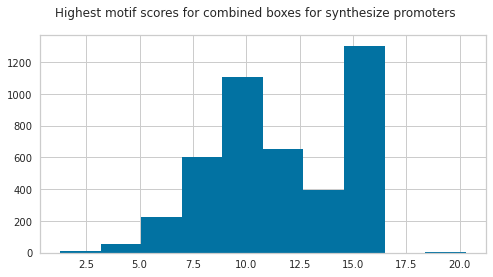

In [103]:
synthesize = XY_dict_all[XY_dict_all['synthesize']==True].copy()


highest_combined = np.amax(np.asarray([synthesize['box_10_70'] + synthesize['box_35_70'], synthesize['box_10_54'] + synthesize['box_35_54'], 
          synthesize['box_10_38'] + synthesize['box_35_38'], synthesize['box_10_32'] + synthesize['box_35_32'], 
            synthesize['box_10_28'] + synthesize['box_35_28'], synthesize['box_10_24'] + synthesize['box_35_24']]), axis=0)

fig, axes = plt.subplots(1,1, figsize=(8,4))

axes.hist(highest_combined)
fig.suptitle('Highest motif scores for combined boxes for synthesize promoters', fontsize=12)

In [104]:
ind_highest_combined = np.argmax(np.asarray([synthesize['box_10_70'] + synthesize['box_35_70'], synthesize['box_10_54'] + synthesize['box_35_54'], 
          synthesize['box_10_38'] + synthesize['box_35_38'], synthesize['box_10_32'] + synthesize['box_35_32'], 
            synthesize['box_10_28'] + synthesize['box_35_28'], synthesize['box_10_24'] + synthesize['box_35_24']]), axis=0)

Motifs = ['Sigma70', 'Sigma54', 'Sigma38', 'Sigma32', 'Sigma28', 'Sigma24']
repeat_Motif = np.tile(Motif, (synthesize.shape[0], 1))

sigma_predict = []
i=0
for row in repeat_Motif:
    predict = row[ind_highest_combined[i]]
    i += 1
    sigma_predict.append(predict)

synthesize['sigma_predict'] = sigma_predict

In [105]:
synthesize['sigma_predict'].value_counts()

Sigma70    3537
Sigma24     285
Sigma38     213
Sigma54     152
Sigma32      84
Sigma28      79
Name: sigma_predict, dtype: int64

In [106]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.index)):
            raise ValueError('cluster_labels.index doesn\'t match data.index')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    
    # normalize across samples. Each genes(features) is its own normal distribution. 
    # PCA().fit_transform returns (n sample, n component), where n component = lesser value of n_features and n_samples
    
    # data has 102 samples each with 3887 features(genes).
    data_pc = PCA().fit_transform(data)
    data_pc = pd.DataFrame(data_pc, index = data.index)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    
    pca = PCA()
    pca.fit(data)
    variance1 = pca.explained_variance_ratio_[0] * 100
    variance2 = pca.explained_variance_ratio_[1] * 100
    
    ax.set_xlabel('PC1 (%.2f %%)' % variance1, fontsize = 16)
    ax.set_ylabel('PC2 (%.2f %%)' % variance2, fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,1))
    
    return ax


In [107]:
XY_dict_synthesized['TOOLBOX'].value_counts()

2    3500
1     800
3      50
Name: TOOLBOX, dtype: int64

<AxesSubplot:xlabel='PC1 (58.47 %)', ylabel='PC2 (41.53 %)'>

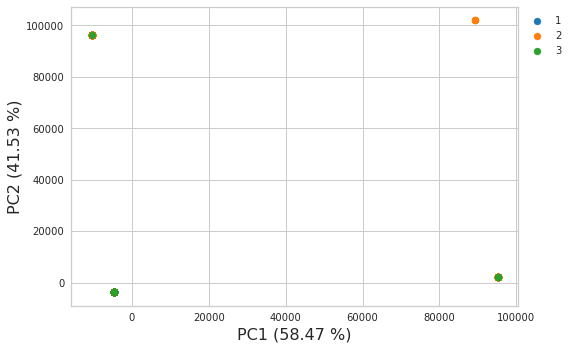

In [108]:
data = synthesize.loc[:, ~synthesize.columns.isin(['label', 'sigma', 'synthesize','sigma_predict'])]
cluster_labels = XY_dict_synthesized['TOOLBOX']
PCA_cluster_plot(data, cluster_labels, ax = None)

# Training 

In [109]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(max_iter = 10000, solver='liblinear'),
        'param_dists': {
            'penalty': ["l1", "l2"],
            'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
            
        }
    },
    
    'SVC': {
        'model': SVC(tol=1e-5),
        'param_dists': {
            'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
            #'kernel' = ['poly', 'rbf'],
            # 'tol' = np.logspace(-6, -2, 10),
            'gamma': [0.01, 0.05, 0.1, 0.5, 1.0]
        }
    },
    'RF': {
        'model': RandomForestClassifier(), 
        'param_dists': {
            'n_estimators': [32, 64, 128, 256, 512, 1024],
            'max_depth': [2,4,8,16,32,64]
        }
    },
    
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_dists':{
            'n_neighbors':  np.linspace(1,3330/10,25, dtype=int),
            'weights': ['uniform', 'distance']
        }
    }
}

In [111]:
# Randomly select 80% samples as the training set
def random_select(X, Y):
    X, Y = shuffle(X, Y)
    scaler = StandardScaler().fit(X)
    X= scaler.transform(X)
    
    split = int(X.shape[0] * 0.8)

    train_X = X[:split]
    train_Y = Y[:split]
    test_X = X[split:]
    test_Y = Y[split:]
    
    return train_X, train_Y, test_X, test_Y

def hyper_search(train_X, train_Y, test_X, test_Y, models, beta=1, average='binary'):
    
    score = {}
    
    opt_classifier_dict = {}

    # It'll tune on the beta choosen.
    
    f_beta = make_scorer(fbeta_score, beta=beta, average=average)
    
    for model_name, model_hyperopt_dict in models.items():

        score[model_name] = {}

        opt_classifier_search = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            #n_iter=50,
            scoring=f_beta,
            n_jobs=4,
            cv=5,
            #verbose=2,
            return_train_score=True
        )
        
        opt_classifier_search.fit(train_X, train_Y)

#         hyperopt_results_df = pd.DataFrame(opt_classifier_search.cv_results_).sort_values(
#             by='mean_test_score',
#             ascending=False
#         )
        
        opt_classifier = opt_classifier_search.best_estimator_
        
        opt_classifier.fit(train_X, train_Y)
        
        predicts = opt_classifier.predict(train_X)
        predicts_test = opt_classifier.predict(test_X)
        
        
        # The tuning is done on f_beta (beta as choosen)
        # return both the precision and f_beta (beta as choosen)
        
        precision_train = precision_score(train_Y, predicts, average=average)
        precision_test = precision_score(test_Y, predicts_test, average=average)
        
        
        fbeta_train = fbeta_score(train_Y, predicts, beta, average=average)
        fbeta_test = fbeta_score(test_Y, predicts_test, beta, average=average)
        
        score_list = [precision_train, precision_test, fbeta_train, fbeta_test]
        
        score[model_name] = score_list
        opt_classifier_dict[model_name] = opt_classifier
        
        score_df = pd.DataFrame(score, index=['precision_train', 'precision_test', 'fbeta_train', 'fbeta_test'])    
        
    return score_df, opt_classifier_dict # opt_classifier_dict stores the best model for each model type.



def run_trials(X, Y, models, beta=1, search_function=hyper_search, n_trials = 5):
    # run five runs of hypertuning and average the score
    
    score_all = []
    
    
    # run five trials and get all five sets of performance metrics and tuning time
    for i in range(n_trials):
        
        # random select 5000 samples as training set
        train_X, train_Y, test_X, test_Y = random_select(X, Y)
        
        score_df, opt_classifier_dict = search_function(train_X, train_Y, test_X, test_Y, models, beta)
        score_a = np.array(score_df)
        
        if i == 0:
            
            score_all = score_a.reshape(1,score_a.shape[0],score_a.shape[1])
        
        else:
            score_all = np.concatenate((score_all, score_a.reshape(1,score_a.shape[0],score_a.shape[1])),axis=0)
        
         
    # calculate the mean score and mean tuning time across five trials    
    mean_score = np.mean(score_all, axis=0)
    
    mean_score_df = pd.DataFrame(mean_score, index=score_df.index, 
                                 columns=models.keys())
    
    return mean_score_df

In [114]:
mean_score_df = run_trials(X, Y, hyperopt_models, n_trials = 5, beta=1)

Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=1 as keyw

In [113]:
mean_score_df

,LR,SVC,RF,KNN
precision_train,0.808382,0.881009,0.998832,1.000000
precision_test,0.792522,0.829020,0.884185,0.780879
fbeta_train,0.820621,0.871916,0.998443,0.998441
fbeta_test,0.813700,0.823209,0.869941,0.820983


In [19]:
mean_score_df.to_csv('mean_score_fbeta0.5')